# Before you start

In this class, we will be using Colab for assignments instead of regular Python files. Colab provides more efficient Google GPU and is easier for setting up. Colab is a very powerful platform and it functions very similarly to a Jupyter notebook. We'll  provide you a few tips on how to use Colab;  make sure you read them carefully!

☝ **Quick Colab Tips:**

*   Make sure you **create a copy** of the Colab before you start coding!!! (File->Save a copy in Drive). If you don't do this, you will lose everything when you close the page and we DON'T want that to happen to you!
*   Make sure you hit every play button that you need in previous cells, so that every function / variables you need is defined.
*   If you don't want to click everything individually, you can click Runtime and you will find "Run Before", "Run After", or "Run All".
*   When you reload the page, the runtime restarts and all variables in the environment are cleared, so you will need to re-run cells.
*   If you make changes to a definition in an earlier cell, remember to run the cell to actually update the definition. Then remember to re-run the cells after, or else they will still be using the previous value. 
*   For more tips on getting started, please take a look at this [video](https://www.youtube.com/watch?v=inN8seMm7UI&ab_channel=TensorFlow).


**Collaboration policy form:**

Before you start coding, make sure to fill out the [collaboration policy form](https://docs.google.com/forms/d/e/1FAIpQLSew1CTPi2WdBOkw3kYINf3WE1iKSdUArJZmwuVFczvndkanFQ/viewform).

# Introduction

Welcome to your first assignment! In this assignment, you will be implementing your very first NLP model (Woohoo!) -- BOW for sentiment classification. In this assignment, you will be using a very useful NLP library (spaCy), and a popular machine learning library (scikit-learn, or sklearn) to help you with preprocessing the data and building the BOW model. In later lectures and assignments, you will learn to implement many of these NLP and ML functions yourself, but in "the real world" it is often more practical to use existing libraries like those provided by spaCy and sklearn than to implement these algorithms from scratch. So, in this assignment, we want you to learn how to use these libraries in a practical setting, and we'll later learn about how they work "under the hood".

The main learning objectives for this assignment are:

1. Use sklearn to implement a standard ML workflow (featurization, designing train-test splits, training a model, and evaluating the model). 
2. Use spaCy for standard NLP preprocessing steps (tokenization, lemmatization, tagging).
3. Understand and implement common featurization approaches for text classifiers (ngrams, weighting schemas, tagging)

The basic workflow for an NLP model contains the following steps:

1. Load data
2. Preprocess data
3. Extract Features
4. Train the model
5. Evaluate the model
6. Analyze model behavior

You will implement this full workflow in Part 1. In Part 2, you will experiment with improvments to step 1 (preprocessing). In Part 3, you will experiment with improvements to step 2 (features). 

# Installation and Imports

☝ **Quick Tip:** You can add "**!**" in front of a Linux command and it can run on Colab! 


In [12]:
!pip install spacy
!pip install sklearn

import csv
import pandas as pd
import random
from google.colab import drive
from functools import reduce
import spacy
import numpy
import pickle
import os
drive.mount("/content/drive", force_remount=True)
import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive




# Part 1: Basic Workflow

### Step 1: Load the raw data from disk and explore the data

In this assignment, we will use a Twitter dataset with social media text. Download the dataset [from Google Drive here](https://drive.google.com/file/d/1AF2v6Cu_gNTe7lzpz_4zsMWMgJ-XjuSh/view?usp=sharing). Drag it into the 'Files' sidebar in this Colab to use the file in our code. 

In the dataset, the tweets are rated for three categories of sentiment: positive, negative and neutral. We will use the tweets in the `text` column and sentiment in the `sentiment` column. Read the pandas documentation [here](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) if you are unfamiliar with dataframes.

In [13]:
# Change this filepath if you've placed the .csv elsewhere in your drive.
FILEPATH = "/content/drive/MyDrive/CSCI1460/Assignment_1/Tweets_5K.csv"

In [14]:
# Input: None
# Output: List<String> raw_tweets, List<Int> labels
def load_data():
  df = pd.read_csv(FILEPATH)
  # print(df.head())

  # Map positive tweets to 1, neutral tweets to 0, and negative tweets to -1.
  def label(val):
    if val == 'positive':
        return 1
    elif val == 'neutral':
        return 0
    elif val == 'negative': 
        return -1
    else:
        return pd.NA

  labels = df['sentiment'].apply(lambda x: label(x))
  texts = df['text'].fillna('NAN') # There's a NAN in the dataset
  return texts.tolist(), labels.tolist()

  

Before you start to preprocess the data, you should always take a look at the dataset and get a sense of the data you're handling.


In [15]:
raw_tweets, labels = load_data()
for p, label in zip(raw_tweets[:10], labels[:10]):
  print(f"{label}:\t{p}\n")

0:	 I`d have responded, if I were going

-1:	 Sooo SAD I will miss you here in San Diego!!!

-1:	my boss is bullying me...

-1:	 what interview! leave me alone

-1:	 Sons of ****, why couldn`t they put them on the releases we already bought

0:	http://www.dothebouncy.com/smf - some shameless plugging for the best Rangers forum on earth

1:	2am feedings for the baby are fun when he is all smiles and coos

0:	Soooo high

0:	 Both of you

1:	 Journey!? Wow... u just became cooler.  hehe... (is that possible!?)



We can use matplotlib to see the ratio between positive, negative and neutral feedback.

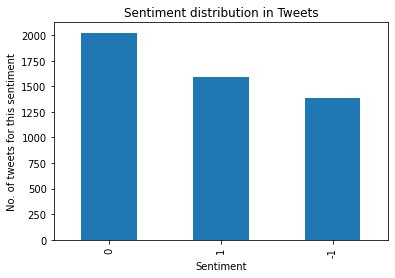

In [16]:
import matplotlib.pyplot as plt
plt.figure()
pd.value_counts(labels).plot.bar(title="Sentiment distribution in Tweets")
plt.xlabel("Sentiment")
plt.ylabel("No. of tweets for this sentiment")
plt.show()

### Step 2: Preprocess the data

In this first part, all of you need to to preprocess is just split the tweets by whitespace.

In [17]:
from pyparsing import restOfLine
# Input: List<String> Raw tweets
# Output: List<List<String>>: preprocessed tweets.
# After preprocessing, each tweet should be represented as a list of words (tokens).
def preprocess(raw_X):
  # TODO Basic tokenization just based on whitespace, with no other preprocessing
  
  return [item.strip().split() for item in raw_X]

### Step 3: Extract Features

In [18]:
from sklearn.feature_extraction import DictVectorizer

# Input: List<List<String>>: preprocessed Tweets
# Output: Matrix<Float>: feature matrix, DictVectorizer: dv, Boolean: isTest
def featurize(preproc_X, dv=None, isTest=False):
  # TODO: BOW feature creation function. 

  dicts = []

  # Assign 1 if the word exists
  for tweet in preproc_X:
    d = {}
    for word in tweet:
      d[word] = 1
      
    dicts.append(d)
    
  # End: TODO.

  # ===== DO NOT MODIFY ======
  if isTest is False:
    dv = DictVectorizer()
    X = dv.fit_transform(dicts)
    return X, dv
  else:
    return dv.transform(dicts), dv
  # =====================

### Step 4: Train the model

In [19]:
from sklearn.linear_model import LogisticRegression
# Input: Matrix<Float> X_train, Vector<Int> y_train
# Output: LogisticRegression clf
def train_classifier(X_train, y_train):
  # TODO train the logistic regression model
  # Hint: use sklearn's documentation, this should be a very simple function

  # The hyperparameters are set to improve the performance
  model = LogisticRegression(
      penalty='l1',
      solver = 'liblinear',
      class_weight = 'balanced',
      max_iter = 500
  ).fit(X_train, y_train)

  return model



### Step 5: Evaluate the model

To evaluate the model, we need to simulate the "real world" setting in which we have trained on our model on the data we have, but now we are using it to assigning labels to data we have never seen before. We will do this using k-fold cross validation. 

Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample. The procedure has a single parameter called `k` that refers to the number of groups that a given data sample is to be split into. As such, the procedure is often called k-fold cross-validation

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import numpy as np

# Input: Matrix<Float> X, Vector<Int> y, LogisticRegression trained_clf
# Output: Float accuracy
# Hint: you will need to reshape y as (-1, 1)
def evaluate_model(X, y, clf):
  # TODO evaluate the logistic regression model
  # Hint: use sklearn's documentation, this should be a very simple function

  y_pred = clf.predict(X)
  y = y.reshape((-1,1))
  acc = accuracy_score(y,y_pred)

  return acc
  
# Input: List<List<String>> X, Vector<Int> y
# Output: List<Float> accuracies
def run_kfold_crossval(X, y, k=5, feature_fn=featurize):
  # TODO implement k-fold cross validation and return a list of accuracies
  # Hint: use sklearn's train_test_split with a 80/20 train/test split
  # Hint: or, investigate other functions from sklearn (sklearn.model_selection.KFold)

  accs = []
  for i in range(k):
    # Set random seed 
    random_seed = i 

    # Split the data into 8:2
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed, shuffle=True)
    X_train, dv = feature_fn(X_train_raw)
    X_test, _ = feature_fn(X_test_raw, dv=dv, isTest=True)

    # Change the data format to numpy ndarray
    if not isinstance(X_train, numpy.ndarray):
      X_train = X_train.toarray()
    y_train = numpy.array(y_train)

    if not isinstance(X_test, numpy.ndarray):
      X_test = X_test.toarray()
    y_test = numpy.array(y_test)

    # Train and Evaluate
    clf = train_classifier(X_train, y_train)
    acc = evaluate_model(X_test, y_test, clf)

    # Record the result
    accs.append(acc)

  return accs


### Step 6: Analyze Model Performance

Let's see how well our model is doing!

In [21]:
from scipy.stats import describe
from math import sqrt

def make_plots(perfs, names):
  means = []
  stds = []
  for i,perf in enumerate(perfs):
   n, minmax, mean, var, skew, kurt = describe(perf)
   means.append(mean)
   stds.append(sqrt(var))
   print("%s:\t%.03f"%(names[i], mean))
  plt.bar(np.arange(len(means)), means, yerr=stds)
  plt.xticks(np.arange(len(names)), names)
  plt.show()


### Run full workflow!

MFC Baseline:	0.405
Basic BOW:	0.597


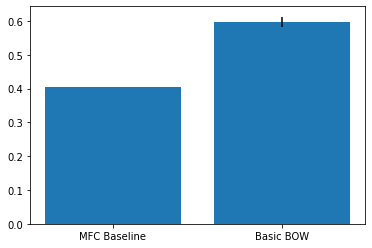

In [22]:
from collections import Counter

K_FOLD = 5
raw_tweets, y = load_data()

X_preproc = preprocess(raw_tweets)
basic_bow_accs = run_kfold_crossval(X_preproc, y, k=K_FOLD, feature_fn=featurize)

# here, we are going generate the "most frequent class" baseline based on the
# training data
counts = Counter(y).values()
mfc_baseline = [max(counts)/sum(counts)] * K_FOLD

# plot the results!
make_plots([mfc_baseline, basic_bow_accs], ["MFC Baseline", "Basic BOW"])  

### ❗ Conceptual Questions (Answer within the Colab cell). 👈👈👈 [Don't miss this section!]
You will need to write some code, or add some print statements to the functions you’ve already written, to help you answer the questions.

**1. What are the dimensions of your feature matrix (X)?**   
  Dimension of Feature Matrix X in the 1st iteration: (4000, 12880)
  
**2. What is the value of X[1460][1460]?**  
  The value of X[1460][1460] in the 1st iteration: 0.0 

**3. What feature does the 1460th column represent?**  
  1460th Feature's name in the 1st iteration: Drawing.

**4. Run one iteration of your k-fold cross validation function to find an example of a word that appears in the test set but never appears in the training set. What word did you find, and what is the tweet in which it occurred?**   
  The word that is not in X_train: jarita  
  The tweet containing the word is: and jarita i\`m going home now and i\`m with two hot guys  drool.

**5. What happens to that new word when the tweet is featurized at test time? I.e., what is the feature representation of the tweet that contains the unknown word?**   
  The shape of feature vector of that tweet at test time will remain the same, which is 1 * 12880. The unknown word in the tweet will be ignored, while the rest words will still be featurizded. 


In [23]:
'''
This part of the code is for ansering conceptual questions. The random_seed is 
set to be 0 means the shuffle is the same as the first round of cross validation 
split.
'''

random_seed = 0
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_preproc, y, test_size=0.2, random_state=random_seed, shuffle=True)
X_train, dv = featurize(X_train_raw)
X_test, _ = featurize(X_test_raw, dv=dv, isTest=True)

if not isinstance(X_train, numpy.ndarray):
  X_train = X_train.toarray()
y_train = numpy.array(y_train)

if not isinstance(X_test, numpy.ndarray):
  X_test = X_test.toarray()
y_test = numpy.array(y_test)

if X_train.shape[0] >= 1460 and X_train.shape[1] >= 1460:
  print("********** Conceptual Questions **********")
  print("Questions 1")
  print("Dimension of Feature Matrix X: " + str(X_train.shape))
  print("\nQuestions 2")
  print("X[1460][1460] = " + str(X_train[1460][1460]))
  print("\nQuestions 3")
  print("1460th Feature's name: " + str(dv.get_feature_names()[1459])) # 1460th column

  # Find the 1st missing word
  missingWord = None
  id = None
  for i in range(len(X_test_raw)):
    for word in X_test_raw[i]:
      if word not in dv.get_feature_names():
        missingWord = word
        id = i
        break

  # Print the info is the missing word is found
  if id:
    print("\nQuestions 4")
    print("The word that is not in X_train: " + missingWord)
    print("The tweet containing the word is: " + " ".join(X_test_raw[id]))

    print("\nQuestions 5")
    vec, _ = featurize([X_test_raw[id]], dv=dv, isTest=True)
    print("The tokens are:")
    print(X_test_raw[id])
    print("The feature representation is: ")
    print(vec.toarray())
    print("The shape of the feature is: ")
    print(vec.shape)
  print("********** Conceptual Questions **********\n\n")


********** Conceptual Questions **********
Questions 1
Dimension of Feature Matrix X: (4000, 12880)

Questions 2
X[1460][1460] = 0.0

Questions 3
1460th Feature's name: Drawing.

Questions 4
The word that is not in X_train: jarita
The tweet containing the word is: and jarita i`m going home now and i`m with two hot guys drool.

Questions 5
The tokens are:
['and', 'jarita', 'i`m', 'going', 'home', 'now', 'and', 'i`m', 'with', 'two', 'hot', 'guys', 'drool.']
The feature representation is: 
[[0. 0. 0. ... 0. 0. 0.]]
The shape of the feature is: 
(1, 12880)
********** Conceptual Questions **********




# Part 2: Improved Preprocessing

In this section, we are going to improve the preprocessing step, but otherwise keep the above workflow the same. Write a new preprocessing function (`preprocessing_part2`) to do the following things. Then call `run_part2_workflow` and observe the difference in performance. 

For Part 2, your preprocessing function should do the following (not necessarily in this order):

* lowercasing
* lemmatization
* remove stop words
* remove punctuation and extra white space 
* use only top 1000 most frequent words, and replace the rest with OOV
* replace numbers with NUM

**Think about how each step affects the next one in the pipeline.** Specifically, one of these steps makes more sense to do last, so make sure your code reflects that.

Your final feature matrix should have 1001 columns (1000 most frequent words and one OOV token).

Use spacy to do these things. You shouldn't need to import any additional libraries (but hint: we've imported the Counter library in a previous cell). You can read the spacy documentation [here](http://spacy.pythonhumanities.com/01_02_linguistic_annotations.html#token-attributes) and [here](https://spacy.io/api/annotation#pos-tagging). 


Processed 0 out of 5000
Processed 1000 out of 5000
Processed 2000 out of 5000
Processed 3000 out of 5000
Processed 4000 out of 5000
MFC Baseline:	0.405
Basic BOW:	0.597
BOW+preproc:	0.643


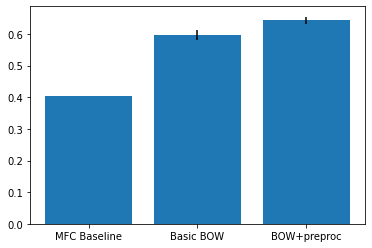

In [24]:
# Input: List<String> raw_tweets, Boolean from_cache, String cache_path
# Output: List<List<String>>: preprocessed tweets.

def preprocessing_part2(raw_tweets):
  
  # parse all the tweets with spacy
  # this will take a couple minutes each time you run it
  # you can save to/load from cache to save time if you want to, but it's 
  # not required

  # ===== DO NOT MODIFY ======
  cache_path = "parsed_tweets.pickle"
  nlp = spacy.load('en_core_web_sm')
  if os.path.exists(cache_path): 
    print("Loading parses from cache at %s"%cache_path)
    parsed_tweets = pickle.load(open(cache_path, 'rb'))
  else:
    parsed_tweets = []
    for i,r in enumerate(raw_tweets):
      if i % 1000 == 0:
        print("Processed %d out of %d"%(i, len(raw_tweets)))
      parsed_tweets.append(nlp(r))
    if cache_path is not None:
       pickle.dump(parsed_tweets, open(cache_path, 'wb'))
  # ============================
  # TODO: preprocessing steps outlined above

  # Process the texts as a stream using nlp.pipe and buffer them in batches
  docs = parsed_tweets

  # Preprocessing
  for i in range(len(docs)):
    tmp = [] 
    for token in docs[i]:
      # Remove stop words, punctuation and white spaces
      if token.is_stop or token.is_punct or token.is_space:
        continue
      # Replace numbers with "NUM"s
      elif token.like_num:
        tmp.append("NUM")
      # Lemmantization and lowercasing
      else:
        tmp.append(token.lemma_.lower())

    docs[i] = tmp[:]

  # Replace the word with OOV that is not in the Top 1000 most frequent words
  word_freq = Counter() # Count
  for doc in docs:
    word_freq += Counter(doc)

  rank = 1000
  most_words = set()
  for item in word_freq.most_common(rank): # Find top 1000
    most_words.add(item[0])

  docs = [[token if token in most_words else "OOV" for token in doc] for doc in docs]

  return docs
  # End TODO

# Use this the first time, then change from_cache to True to load from cache.
X_preproc = preprocessing_part2(raw_tweets)

better_preproc_accs = run_kfold_crossval(X_preproc, y, k=K_FOLD)

make_plots([mfc_baseline, basic_bow_accs, better_preproc_accs],
           ["MFC Baseline", "Basic BOW", "BOW+preproc"])  

# Part 3: Improved Featurization

In this section, we will expand the featurize function to include more advanced and sophisticated features. You will now add 5-grams as features along with the unigrams to preserve the order of the sentence.

Loading parses from cache at parsed_tweets.pickle
MFC Baseline:	0.405
Basic BOW:	0.597
BOW+preproc:	0.643
Better Features:	0.644


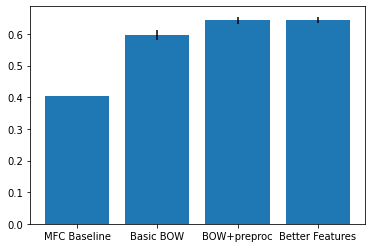

In [25]:
# Input: List<List<String>>: preproc_X
# Output: Matrix<Float>: feature matrix, DictVectorizer: dv, Boolean: isTest
def featurize_part3(preproc_X, dv=None, isTest = False):
  # TODO add 5-gram features to your feature function in addition to unigrams

  dicts = []
  # Assign 1 the existing word
  for tweet in preproc_X:
    d = {}
    for word in tweet:
      d[word] = 1

    # Add 5-gram features
    n = 5
    ngrams = zip(*[tweet[i:] for i in range(n)])
    for ngram in ngrams:
      if len(ngram) == n:
        d[" ".join(ngram)] = 1

    dicts.append(d)

  # End: TODO.
  # ===== DO NOT MODIFY ======
  if isTest is False:
    dv = DictVectorizer()
    X = dv.fit_transform(dicts)
    return X, dv
  else:
    return dv.transform(dicts), dv
  # ====================

X_preproc = preprocessing_part2(raw_tweets)

better_feature_accs = run_kfold_crossval(X_preproc, y, k=K_FOLD,
                                         feature_fn=featurize_part3)

make_plots([mfc_baseline, basic_bow_accs, better_preproc_accs, better_feature_accs],
           ["MFC Baseline", "Basic BOW", "BOW+preproc", "Better Features"])  

# Extra credit challenge!

Congratulations on finishing all the mandatory parts in the first assignment! Hope you had a good time playing around with spaCy and sklearn. 

Here in this section, you will have the freedom to play around with other features mentioned in class, or that you come up with yourself! You will get an extra point if you are able to raise the Logistic Regression accuracy rate to >=68%.

Loading parses from cache at parsed_tweets.pickle
Baseline:	0.405
BOW:	0.597
pre+BOW:	0.643
Better:	0.644
Best:	0.652


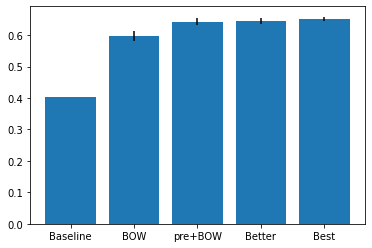

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Input: List<String> raw_tweets, Boolean from_cache, String cache_path
# Output: List<List<String>>: preprocessed tweets.
def preprocessing_ECC(raw_tweets):

  # ===== DO NOT MODIFY ======
  cache_path = "parsed_tweets.pickle"
  nlp = spacy.load('en_core_web_sm')
  if os.path.exists(cache_path): 
    print("Loading parses from cache at %s"%cache_path)
    parsed_tweets = pickle.load(open(cache_path, 'rb'))
  else:
    parsed_tweets = []
    for i,r in enumerate(raw_tweets):
      if i % 1000 == 0:
        print("Processed %d out of %d"%(i, len(raw_tweets)))
      parsed_tweets.append(nlp(r))
    if cache_path is not None:
       pickle.dump(parsed_tweets, open(cache_path, 'wb'))
  # ============================
  # TODO: preprocessing steps outlined above

  # Load the data
  tweets = parsed_tweets

  # Data preprocessing
  docs = []
  for i, tweet in enumerate(tweets):
    tmp = [] 
    for j, token in enumerate(tweet):
      # Check stop word, punctation, space, url, email
      if token.is_stop or token.is_punct or token.is_space or token.like_url or token.like_email:
        continue
      # Remove '`' and merge
      elif '`' in token.text:
        if len(token.text) > 1: # ignore '`'
          w = token.text.split('`')
          tmp.append("".join(w).lower())
      # Replace numbers with "NUM"
      elif token.like_num:
        tmp.append("NUM")
      # Remove tokens, like '=', '<3', etc.
      elif token.pos_ == "SYM": #not token.text.isdigit() and not token.text.isalpha():
        continue
      # Lemmatization and lowercasing
      else:
        tmp.append(token.lemma_.lower())

    docs.append(tmp[:])

  # for doc in docs[:20]:
  #   print(doc)
  
  # Replace the word with OOV that is not in the most frequent words
  word_freq = Counter()
  for doc in docs:
    word_freq += Counter(doc)

  rank = 840
  most_words = set()
  for item in word_freq.most_common(rank):
    most_words.add(item[0])

  docs = [[token if token in most_words else "OOV" for token in doc] for doc in docs]

  # '''
  # Add dependency
  for i in range(len(tweets)):
    for token in tweets[i]:
      if token.dep_ == any(["compound", "amod"]): # "acomp", "xcomp", "ccomp"
        feature = '_'.join([token.text.lower(), token.head.text.lower()])
        docs[i].append(feature)
      # docs[i].append(token.dep_)
  # '''

  # for doc in docs[:100]:
  #   print(doc)
  
  return docs

# Input: List<List<String>>: preproc_X
# Output: Matrix<Float>: feature matrix, Vectorizer: dv, Boolean: isTest
def featurize_challenge(preproc_X, dv=None, isTest = False):
  # '''
  preproc_X = [" ".join(doc) for doc in preproc_X]

  # Apply TF-IDF Weighting
  if isTest is False:
    dv = TfidfVectorizer(
        min_df = 1,
    )
    X = dv.fit_transform(preproc_X)
    return X, dv
  else:
    return dv.transform(preproc_X), dv
  # '''

X_preproc = preprocessing_ECC(raw_tweets)
# X_preproc = X_preproc[0:10]
# y = y[0:10]

best_feature_accs = run_kfold_crossval(X_preproc, y, k=K_FOLD,
                                         feature_fn=featurize_challenge)

make_plots([mfc_baseline, basic_bow_accs, better_preproc_accs, better_feature_accs, best_feature_accs],
           ["Baseline", "BOW", "pre+BOW", "Better", "Best"])  


# Submission Instructions
Please submit this Colab as **two** files to Gradescope:
1.   A `.py` file: Click File > Download > Download .py
2.   A `.ipynb` file with outputs: Click Runtime > Run All, and then after all outputs are complete, click File > Download > Download .ipynb

Please ensure that the `.ipynb` contains actual function outputs (and not leftover print statements, for instance). We will run your `.ipynb` file; if our outputs don't match the outputs in your submitted file (within reason), you will receive a 0 on this assignment.

Last updated: 20 Sep 2022